In [1]:
import ConfigParser
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')
import pandas as pd

%matplotlib inline

In [41]:
conf_path = './config/config_parse_user_lookups.ini'
conf = ConfigParser.ConfigParser()
conf.read(conf_path)

#paths 
summary_path = conf.get('Paths', 'summary_path') 
uniqe_users_path = conf.get('Paths', 'uniqe_users_path')
filtere_path = conf.get('Paths', 'filtere_path')

#params

## Join the summary and unique user files

Open the data frame that summarizes the user_lookups. Note that this file uses the ASCII-31 unit separator ('\x1f') as the column delimiter. This avoids issues of users who use spaces and tabs etc. in their location field.

In [3]:
df_summary = pd.read_csv(summary_path, sep='\x1f')
print df_summary.shape

(185533, 7)


In [4]:
df_summary.head()

id    screen_name                 location  friends_count  \
0    34083819       tomahs50               Maine, USA          251.0   
1   270593546    wolfnayley_          California, USA          374.0   
2  4018369694       w0ahjuju  South San Francisco, CA           57.0   
3   414373611   Morgan_Lee_K                      716          655.0   
4  2469601123  mizzoubayarea   San Francisco Bay Area          101.0   

   followers_count  statuses_count  listed_count  
0            120.0          1981.0           6.0  
1            575.0         41633.0           3.0  
2             24.0            81.0           0.0  
3           1053.0         40005.0           5.0  
4             76.0            99.0           4.0

Add number of tweets from sample to it

In [5]:
# This file contains user ids and number of geotagged tweets in sample
df_unique = pd.read_csv(uniqe_users_path)
print df_unique.shape

(190428, 2)


In [6]:
df_summary = df_summary.merge(df_unique, left_on='screen_name', right_on='Username').drop('Username', axis=1)

In [7]:
df_summary.head()

id    screen_name                 location  friends_count  \
0    34083819       tomahs50               Maine, USA          251.0   
1   270593546    wolfnayley_          California, USA          374.0   
2  4018369694       w0ahjuju  South San Francisco, CA           57.0   
3   414373611   Morgan_Lee_K                      716          655.0   
4  2469601123  mizzoubayarea   San Francisco Bay Area          101.0   

   followers_count  statuses_count  listed_count  Number_Tweets  
0            120.0          1981.0           6.0              1  
1            575.0         41633.0           3.0             12  
2             24.0            81.0           0.0              6  
3           1053.0         40005.0           5.0              4  
4             76.0            99.0           4.0              1

## Boxplots

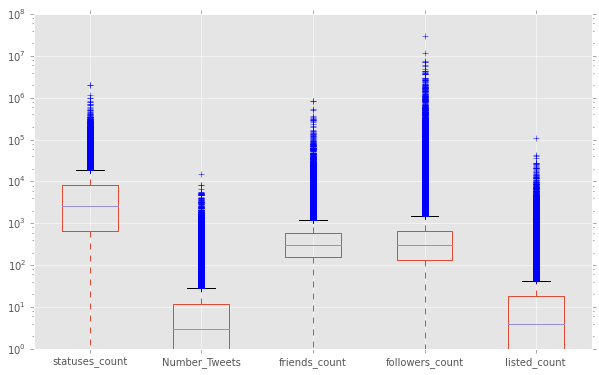

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
a= df_summary[['statuses_count','Number_Tweets', 'friends_count', 'followers_count', 'listed_count']].boxplot();
ax.set_yscale('log')

## Plot histograms

### Total number of tweets

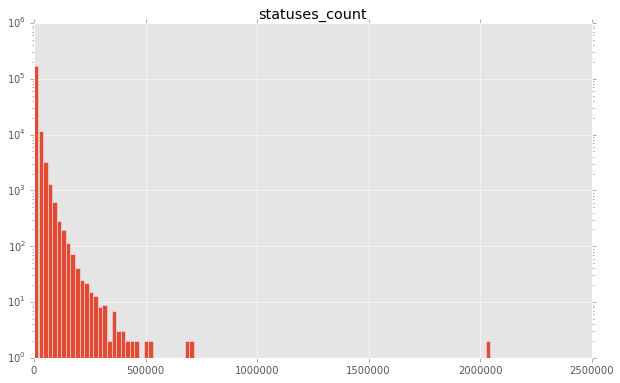

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
df_summary.hist(column='statuses_count', ax=ax, bins=100)
ax.set_yscale('log')

### Number of geotagged tweets in sample

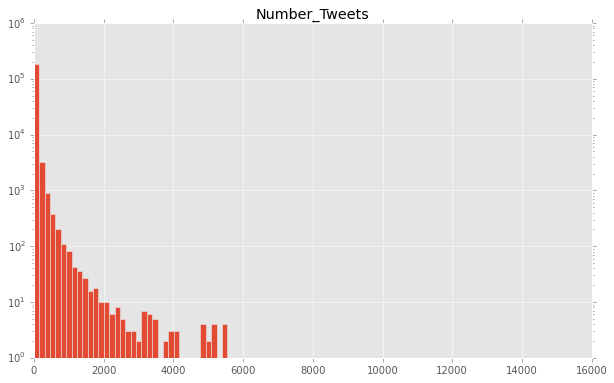

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
df_summary.hist(column='Number_Tweets', ax=ax, bins=100)
ax.set_yscale('log')

In [34]:
df_summary[(df_summary.Number_Tweets > 75) & (df_summary.Number_Tweets < 2000)].count()

id                 11125
screen_name        11125
location            8432
friends_count      11125
followers_count    11125
statuses_count     11125
listed_count       11125
Number_Tweets      11125
dtype: int64

### Number of friends 

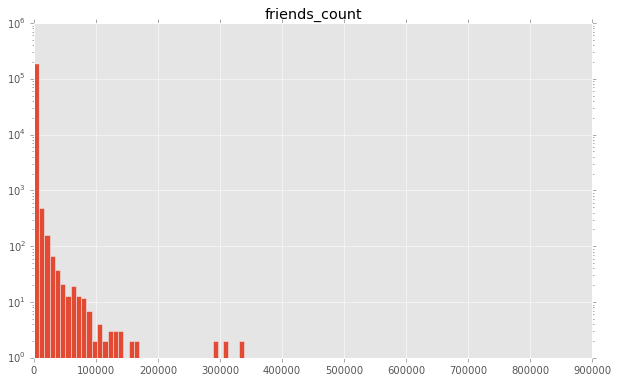

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
df_summary.hist(column='friends_count', ax=ax, figsize=(9,6), bins=100)
ax.set_yscale('log')

In [24]:
df_summary[(df_summary.friends_count > 1) & (df_summary.friends_count < 10000)].count()

id                 183846
screen_name        183846
location           138657
friends_count      183846
followers_count    183846
statuses_count     183846
listed_count       183846
Number_Tweets      183846
dtype: int64

### Number of followers

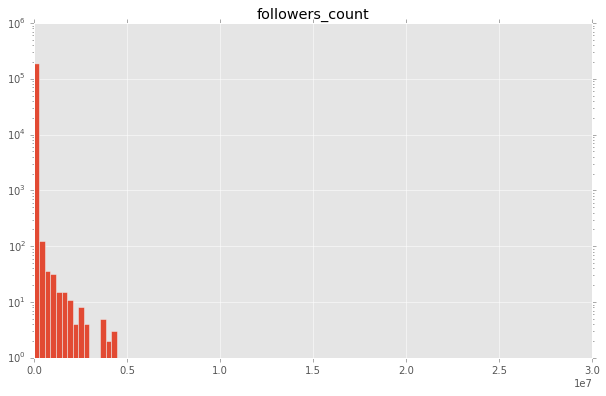

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
df_summary.hist(column='followers_count', ax=ax, figsize=(9,6), bins=100)
ax.set_yscale('log')

In [26]:
df_summary[(df_summary.followers_count > 1) & (df_summary.followers_count < 10000)].count()

id                 179560
screen_name        179560
location           134849
friends_count      179560
followers_count    179560
statuses_count     179560
listed_count       179560
Number_Tweets      179560
dtype: int64

### Number of favorites

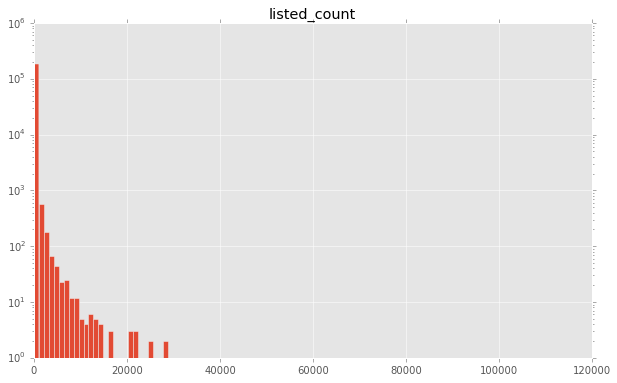

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
df_summary.hist(column='listed_count', ax=ax, figsize=(9,6), bins=100)
ax.set_yscale('log')

In [14]:
df_summary.loc[df_summary.followers_count.idxmax()]

id                     26257166
screen_name        SportsCenter
location            Bristol, CT
friends_count              1674
followers_count     2.96355e+07
statuses_count            82977
listed_count              42459
Number_Tweets                 4
Name: 30109, dtype: object

# Filtering for egonet downloads

The Twitter API is rate limited to downloading one egonet per minute. With 190k users, that is too long. So I am filtering this list down to about 10k "high quality" users.

In [36]:
min_tweets = 75
max_tweets = 2000
max_friends = 10000
max_followers = 10000

In [39]:
mask_tweets = (df_summary.Number_Tweets >= min_tweets) & (df_summary.Number_Tweets <= max_tweets) & \
                (df_summary.friends_count <= max_friends) & (df_summary.followers_count <= max_followers)

In [44]:
# Total users after filtering
sum(mask_tweets)

10983

In [45]:
# Write their usernames to file
df_summary.screen_name[mask_tweets].to_csv(filtere_path, index=False)